#### Poor persons option backtest
```
Below is an attempt to write a naive backtest that attempts to replicate the performance of a option trading strategy propose by CBOE.  The strategy from CBOE is displyed below verbatim.
```

![cboe-cndr](static/cboe_cndr.png)

```
"
Cboe S&P 500 Iron Condor Index (CNDR)

The Cboe S&P 500 Condor IndexSM  (CNDR) is inspired by the condor option strategy. The objective of a condor option spread is to mine "out-of-the-money" option volatility premium with limited risk.  A generic condor option spread is short an out-of-the-money  straddle and long further out-of-the money call and put that bound the risk of the straddle. 

The CNDR index follows this strategy and sells a butterfly spread of the S&P 500® one-month options (SPX options).  More precisely,  it tracks the value of a hypothetical portfolio that overlays a butterfly spread of SPX  options over one-month Treasury bills . The short SPX straddle is at-the-money and the long SPX call and put are 5% out-of-the-money.  to guarantee solvency, the Treasury bills cover ten times the maximum loss of the short butterfly spread. 

The BFLY portfolio is rebalanced monthly, usually  at 11 am ET every third Friday after the options in the butterfly spread expire. A new SPX butterfly spread is then sold. 

The CNDR   portfolio is rebalanced monthly after  the expiration of SPX options, typically 11 am ET every  third Friday. New SPX  options are then bought and sold.
"
excerpt from 
http://www.cboe.com/index/dashboard/cndr
https://www.cboe.com/publish/micropdf/CBOE-SP500-Iron-Condor-CNDR-Methodology-Paper.pdf
```
## *** DISCLAIMER ***
```
Until below backtest pnl performs like CBOE CNDR index, do not trust backtest one bit.  Once pnl "matches" only trust it a bit.
```


In [373]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
from py_vollib.ref_python.black_scholes_merton import black_scholes_merton

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [390]:
import datetime as dt
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
start_date = '1980-1-1'
future_date = datetime.datetime.now().date()+datetime.timedelta(days=45)
end_date = future_date.strftime('%Y-%m-%d')
print(start_date,end_date)

def get_business_day(date):
    while date.isoweekday() > 5 or date in cal.holidays():
        date += dt.timedelta(days=1)
    return date

first_bday_of_month = [get_business_day(d).date() 
                           for d in pd.date_range(start_date, end_date, freq='BMS')]

1980-1-1 2021-01-06


In [391]:
first_bday_of_month[0]

datetime.date(1980, 1, 2)

In [473]:
ticker_history

,Open,High,Low,Close,Volume,Dividends,Stock Splits,implied_vol
Date,,,,,,,,
1993-01-29,26.098207,26.098207,25.968366,26.079659,1003200,0.0,0,12.420000
1993-02-01,26.098205,26.265144,26.098205,26.265144,480500,0.0,0,12.330000
1993-02-02,26.246586,26.339331,26.190940,26.320782,201300,0.0,0,12.250000
1993-02-03,26.357880,26.617563,26.339331,26.599014,529400,0.0,0,12.120000
1993-02-04,26.691763,26.765958,26.394982,26.710312,531500,0.0,0,12.290000
...,...,...,...,...,...,...,...,...
2020-11-16,360.980011,362.779999,359.589996,362.570007,74541100,0.0,0,22.450001
2020-11-17,359.970001,361.920013,358.339996,360.619995,66111000,0.0,0,22.709999
2020-11-18,360.910004,361.500000,356.239990,356.279999,70591300,0.0,0,23.840000


In [596]:
class MyBackTester:
    def __init__(self,initial_deposit=100):
        self.initial_deposit = initial_deposit
    
    def run_backtest(self,ticker_history,days=252*10):
        '''
        ticker_history is the df from `yfinance`.
        '''
        df = pd.DataFrame()
        df['close'] = ticker_history.Close
        df['ret']= np.log(df.close).diff(1)
        df['realized_vol'] = df.ret.rolling(21).std()*np.sqrt(252)*100
        if 'implied_vol' in ticker_history.columns:
            df['implied_vol'] = ticker_history.implied_vol
        else: # use realized volatility as implied (which will be off, should maybe model with a curve)
            df['implied_vol'] = df.realized_vol
        
        df['actual_ret']= df.close.pct_change(45)
        df['ret_sd'] = df.actual_ret.rolling(45).std()
        df['ret_mean'] = df.actual_ret.rolling(45).mean()
        df = df.dropna()
        
        mydf = df.iloc[-1*days:].copy()
        
        start_date = mydf.index[0]
        self.cash = self.initial_deposit
        self.history = [{'date':start_date,'cash':self.initial_deposit}]
        self.positions = {}
        self.closed_positions = []
        
        def myfunc(ser):
            rows = mydf.loc[ser.index]
            row = rows.iloc[-1:]
            # every day manager positions
            self._manage_positions(row)
            return 0
        rol = mydf.close.rolling(window=2)
        _=rol.apply(myfunc, raw=False)
        pdf = pd.DataFrame(self.history)
        pdf.index = pdf.date
        pdf=pdf.drop(columns=['date'])
        return df, pdf

    def _manage_positions(self,row):
        todelete = []
        m=0
        if len(self.positions)==0:
            # open position if there are no positions
            strategy = IronCondor()
            if strategy.open_confidence(row) > 0.5:
                strategy.open_position(row,self)
                self.positions[strategy.name]=strategy
        else:
            # manage existing
            for k,v in self.positions.items():
                action = v.manage_position(row)
                if action == 'close_position':
                    v.close_position(row,self)
                    todelete.append(k)
            for k in todelete:
                self.closed_positions.append(self.positions.pop(k))

        mytoday = {'date':row.index[-1],'cash':self.cash}
        self.history.append(mytoday)

class Strategy:
    def __init__(self):
        self.slippage = 0.0 # one way
        self.entry_row = None
        self.exit_row = None
        self.entry_price = None
        self.exit_price = None
        self.multiplier = 1
    def open_confidence(self,row):
        raise NotImplementedError()
    def compute_price(self,row):
        raise NotImplementedError()
    def manage_position(self,row):
        raise NotImplementedError()
    def open_position(self,row,portfolio):
        # positive value is credit
        slippage = (1-self.slippage)
        self.entry_price = slippage*self.compute_price(row)
        justone = False
        if justone:
            self.multiplier = 1
        else:
            # 1 percent of cash value
            m = int((0.01*portfolio.cash)/self.entry_price)
            if m > 1:
                self.multiplier = m
            else:
                self.multiplier = 1
        portfolio.cash+=1*self.multiplier*self.entry_price
        self.entry_row = row
        
    def close_position(self,row,portfolio):
        # negative value is debit.
        slippage = (1+self.slippage)
        self.exit_price = slippage*self.compute_price(row)
        portfolio.cash+=-1*self.multiplier*self.exit_price
        self.exit_row = row
        
class IronCondor(Strategy):
    name = 'IronCondor'
    def open_confidence(self,row):
        return 1
    def _get_dte(self,row):
        if self.entry_row is None:
            '''
            # # option 1. # assuming you always can find a 45 dte contract
            # # easy but far from reality
            # dte = 45
            '''
            # option 2. # locate future contract first business day of following month.
            # still not quite the same as first monday.
            today = row.index[-1].date()
            contract_dates = np.array(first_bday_of_month)
            index = np.argmin(np.abs([x.days for x in contract_dates-today]))
            next_contrast_date = contract_dates[index+1]
            dte = (next_contrast_date-today).days
        else:
            dte = 45-(row.index[-1]-self.entry_row.index[-1]).days
        return 1 if dte<=1 else dte
    
    def compute_price(self,row):
        dte = self._get_dte(row)
        time_to_expiry_years = dte/365
        
        underlying_price = row.close.values[-1]
        ret_mean = row.ret_mean.values[-1]
        ret_sd = row.ret_sd.values[-1]
        sigma = row.implied_vol.values[-1]/100
        
        # http://www.cboe.com/index/dashboard/cndr

        p1sd_strike = underlying_price*(1+ret_mean+0.7*ret_sd)
        m1sd_strike = underlying_price*(1+ret_mean+0.7*ret_sd)

        p2sd_strike = underlying_price*(1+ret_mean-2*ret_sd)
        m2sd_strike = underlying_price*(1+ret_mean-2*ret_sd)
        
        S = underlying_price
        K = p1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        call_1sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)
        
        S = underlying_price
        K = m1sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        put_1sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)

        S = underlying_price
        K = p2sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        call_2sd_price = black_scholes_merton('c', S, K, t, r, sigma, q)
        
        S = underlying_price
        K = m2sd_strike
        q = 0
        t = time_to_expiry_years
        r = 0
        sigma = sigma
        put_2sd_price = black_scholes_merton('p', S, K, t, r, sigma, q)
        
        return call_1sd_price+put_1sd_price-call_2sd_price-put_2sd_price
    
    def manage_position(self,row):
        dte = self._get_dte(row)
        slippage = (1+self.slippage)
        current_price = slippage*self.compute_price(row)
        myreturn = (self.entry_price-current_price)/self.entry_price

        #if dte < 3:
        #    return 'close_position'
        #if myreturn > .5:
        #    return 'close_position'
        if myreturn < -1: # why even need this if CNDR is risk defined.
            return 'close_position'        
        if row.index[-1] in first_bday_of_month:
            return 'close_position'
        return 'maintain_position'


In [597]:
# download and read CNDR index from CBOE website
cndr = pd.read_csv('static/CNDR_Data.csv')
cndr.index=[datetime.datetime.strptime(x,'%m/%d/%Y').date() for x in cndr.time]
cndr=cndr.drop(columns=['time','volume','open','high','low'])
cndr=cndr.rename(columns={'close':'cndr'})

In [598]:
cndr.head()

,cndr
1986-06-20,100.0
1986-06-23,100.0
1986-06-24,100.0
1986-06-25,100.0
1986-06-26,100.0


In [599]:
# get historical daily price for SPY
symbol = '^VIX'
tick = yf.Ticker(symbol)
vix_history = tick.history(period="max")
vix_history = vix_history.drop(
    columns=['Open','High','Low','Volume','Dividends','Stock Splits']
)
vix_history = vix_history.rename(columns={'Close':'implied_vol'})

symbol = 'SPY'
tick = yf.Ticker(symbol)
ticker_history = tick.history(period="max")
ticker_history = pd.merge(
    ticker_history,vix_history,
    how='left',left_index=True,right_index=True)

In [600]:
ticker_history.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,implied_vol
Date,,,,,,,,
1993-01-29,26.098207,26.098207,25.968366,26.079659,1003200,0.0,0,12.42
1993-02-01,26.098205,26.265144,26.098205,26.265144,480500,0.0,0,12.33
1993-02-02,26.246586,26.339331,26.190940,26.320782,201300,0.0,0,12.25
1993-02-03,26.357880,26.617563,26.339331,26.599014,529400,0.0,0,12.12
1993-02-04,26.691763,26.765958,26.394982,26.710312,531500,0.0,0,12.29


In [601]:
# backtest iron-condor for past 10 years
myportfolio = MyBackTester(initial_deposit=100)
hdf,pdf = myportfolio.run_backtest(ticker_history,days=252*20)

In [602]:
hdf.head()

,close,ret,realized_vol,implied_vol,actual_ret,ret_sd,ret_mean
Date,,,,,,,
1993-06-08,26.668728,-0.009044,11.793271,14.74,0.014174,0.012296,0.001213
1993-06-09,26.761911,0.003488,11.827997,13.96,0.012694,0.012282,0.001200
1993-06-10,26.780537,0.000696,11.750244,13.31,0.016265,0.012483,0.001488
1993-06-11,26.892370,0.004167,11.806925,12.71,0.016914,0.012686,0.001759
1993-06-14,26.855091,-0.001387,10.924108,12.33,0.016937,0.012808,0.002295


In [603]:
pdf.head()

,cash
date,
2000-11-09,100.000000
2000-11-10,94.905707
2000-11-13,94.905707
2000-11-14,94.905707
2000-11-15,94.905707


In [604]:
mdf = pd.merge(pdf,cndr,how='left',left_index=True,right_index=True)

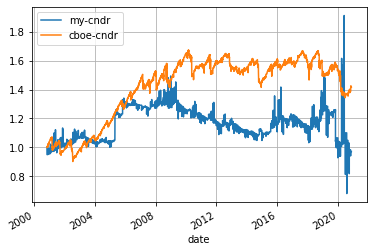

In [605]:
(mdf.cash/mdf.cash.iloc[0]).plot(label='my-cndr')
(mdf.cndr/mdf.cndr.iloc[0]).plot(label='cboe-cndr')
plt.legend()
plt.grid(True)